In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)

import numpy as np
np.set_printoptions(linewidth=10000, precision=3)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('train_df.csv')
df

,year,round_num,home_team,away_team,ladder_position_home,ladder_position_away,home_ladder_pos_diff,home_win
0,2010,24,Knights,Broncos,13,9,-4,1
1,2010,24,Cowboys,Bulldogs,16,14,-2,0
2,2010,25,Wests Tigers,Storm,3,5,2,1
3,2010,25,Roosters,Sea Eagles,7,6,-1,1
4,2010,25,Warriors,Broncos,8,9,1,1
...,...,...,...,...,...,...,...,...
5562,2015,1,Sharks,Raiders,0,0,0,0
5563,2017,1,Sharks,Broncos,0,0,0,0
5564,2019,1,Roosters,Rabbitohs,0,0,0,0
5565,2020,1,Raiders,Titans,0,0,0,1


In [3]:
df.isnull().sum()

year                    0
round_num               0
home_team               0
away_team               0
ladder_position_home    0
ladder_position_away    0
home_ladder_pos_diff    0
home_win                0
dtype: int64

In [4]:
df.home_win.mean()

np.float64(0.5726603197413328)

In [23]:
# train test split:

train = df[df.year<2024].reset_index(drop=True)
test = df[df.year>=2024].reset_index(drop=True)

X_train = train.drop(columns=['year', 'home_win'])
y_train = train.home_win

X_test = test.drop(columns=['year', 'home_win'])
y_test = test.home_win

train.shape, test.shape

((5190, 8), (377, 8))

In [24]:
num_cols = X_train.select_dtypes(exclude='object').columns
cat_cols = X_train.select_dtypes(include='object').columns
num_cols, cat_cols

(Index(['round_num', 'ladder_position_home', 'ladder_position_away',
        'home_ladder_pos_diff'],
       dtype='object'),
 Index(['home_team', 'away_team'], dtype='object'))

In [25]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(), cat_cols), # WRONG - it uses a different OHE for home and away team - combine it (but lose H/A info)?
])

X_train_prep = preprocess.fit_transform(X_train)
X_test_prep = preprocess.transform(X_test)

X_train_prep, X_test_prep

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 31140 stored elements and shape (5190, 52)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 2262 stored elements and shape (377, 52)>)

In [49]:
lr = LogisticRegression()
lr.fit(X_train_prep, y_train)
# lin_reg.coef_
y_pred_proba_train = lr.predict_proba(X_train_prep)
y_pred_train = lr.predict(X_train_prep)
y_pred_proba_test = lr.predict_proba(X_test_prep)
y_pred_test = lr.predict(X_test_prep)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [50]:
accuracy_score(y_train, y_pred_train)
accuracy_score(y_test, y_pred_test)

0.63121387283237

0.5941644562334217

<Axes: >

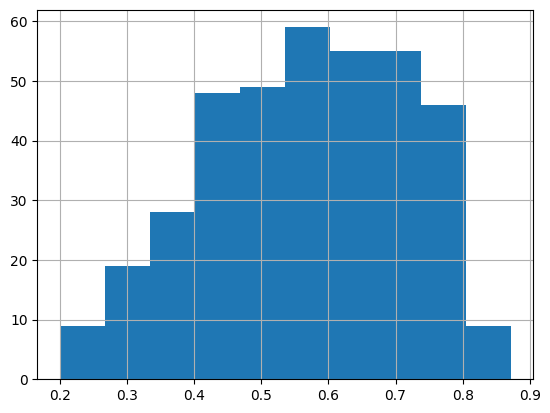

In [51]:
pd.Series(y_pred_proba_test[:,1]).hist()

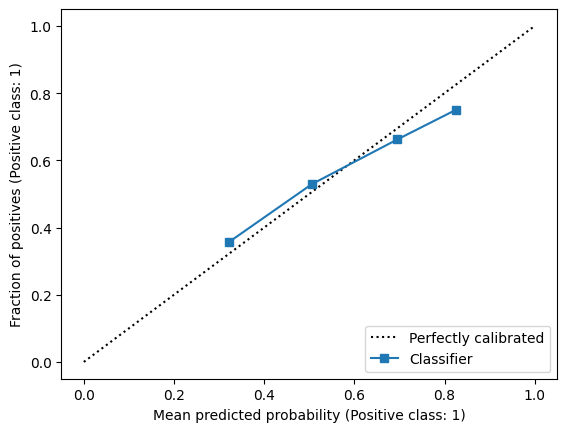

In [52]:
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_predictions(y_test, y_pred_proba_test[:,1])

In [53]:
test['pred'] = y_pred_test
test['pred_proba'] = y_pred_proba_test[:,1]
test

,year,round_num,home_team,away_team,ladder_position_home,ladder_position_away,home_ladder_pos_diff,home_win,pred_proba,pred
0,2024,13,Panthers,Dragons,2,12,10,0,0.780562,1
1,2024,13,Dolphins,Raiders,4,8,4,0,0.535116,1
2,2024,13,Roosters,Cowboys,5,11,6,0,0.736590,1
3,2024,13,Knights,Bulldogs,7,10,3,0,0.529474,1
4,2024,13,Eels,Sharks,15,1,-14,1,0.372246,0
...,...,...,...,...,...,...,...,...,...,...
372,2025,1,Wests Tigers,Knights,0,0,0,0,0.522364,1
373,2025,1,Sea Eagles,Cowboys,0,0,0,1,0.664663,1
374,2025,1,Roosters,Broncos,0,0,0,0,0.547304,1
375,2024,1,Titans,Dragons,0,0,0,0,0.517649,1


In [54]:
test.groupby('year').pred_proba.mean()
test.groupby('round_num').pred_proba.mean()

year
2024    0.566945
2025    0.565124
Name: pred_proba, dtype: float64

round_num
1     0.578973
2     0.564406
3     0.495099
4     0.489688
5     0.590740
6     0.578272
7     0.520438
8     0.603573
9     0.551523
10    0.575194
11    0.542779
12    0.580681
13    0.555215
14    0.627641
15    0.502659
16    0.500253
17    0.606322
18    0.597921
19    0.535737
20    0.639989
21    0.591158
22    0.552619
23    0.493715
24    0.665518
25    0.503231
26    0.615070
27    0.556505
28    0.639164
29    0.667329
30    0.670853
31    0.722776
Name: pred_proba, dtype: float64

/var/folders/f0/lg0qyy8n1gg_khp86kzryb8h0000gn/T/ipykernel_7238/2260686862.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test.groupby('round_num').apply(lambda x: accuracy_score(x.home_win, x.pred)).plot()


<Axes: xlabel='round_num'>

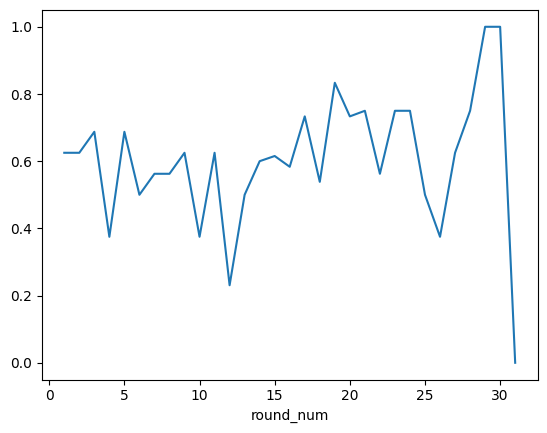

In [55]:
test.groupby('round_num').apply(lambda x: accuracy_score(x.home_win, x.pred)).plot()

In [11]:
# retrain on all data
# now get mlflow and deployment working!!!